#Imports

In [1]:
from __future__ import print_function
from urllib.request import urlretrieve
from torch.utils.data import Dataset
from torch import optim

import os
import pickle as pkl
import numpy as np
import torch

import torch
import torch.utils.data

from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import os
import torch.nn as nn

import matplotlib.pyplot as plt
from IPython.display import clear_output

import imageio
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from google.colab import drive
drive.mount('/content/drive')

# Parameters

In [2]:
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

batch_size = 64
log_interval = 16
epochs = 20
bottleneck_dim = 32
use_conv = True
plot_images = True
plot_loss = True
save_images = False

root = os.getcwd()
print(f"Current working directory: {root}")

Current working directory: /content


# Load data

## MNIST binary

In [0]:
def load_mnist_binarized(root):
    datapath = os.path.join(root, 'bin-mnist')
    if not os.path.exists(datapath):
        os.makedirs(datapath)
    dataset = os.path.join(datapath, "mnist.pkl.gz")

    if not os.path.isfile(dataset):

        datafiles = {
            "train": "http://www.cs.toronto.edu/~larocheh/public/"
                     "datasets/binarized_mnist/binarized_mnist_train.amat",
            "valid": "http://www.cs.toronto.edu/~larocheh/public/datasets/"
                     "binarized_mnist/binarized_mnist_valid.amat",
            "test": "http://www.cs.toronto.edu/~larocheh/public/datasets/"
                    "binarized_mnist/binarized_mnist_test.amat"
        }
        datasplits = {}
        for split in datafiles.keys():
            print("Downloading %s data..." % (split))
            datasplits[split] = np.loadtxt(urlretrieve(datafiles[split])[0])

        pkl.dump([datasplits['train'], datasplits['valid'], datasplits['test']], open(dataset, "wb"))

    x_train, x_valid, x_test = pkl.load(open(dataset, "rb"))
    return x_train, x_valid, x_test


class BinMNIST(Dataset):
    """Binary MNIST dataset"""

    def __init__(self, data, device='cpu', transform=None):
        h, w, c = 28, 28, 1
        self.device = device
        self.data = torch.tensor(data, dtype=torch.float).view(-1, c, h, w)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample.to(self.device)


def get_binmnist_datasets(root, device='cpu'):
    x_train, x_valid, x_test = load_mnist_binarized(root)
    x_train = np.append(x_train, x_valid, axis=0)  # https://github.com/casperkaae/LVAE/blob/master/run_models.py (line 401)
    return BinMNIST(x_train, device=device), BinMNIST(x_test, device=device), BinMNIST(x_test, device=device)

## Quick, Draw!

In [0]:
class Sketch(Dataset):
    """Sketch dataset"""

    def __init__(self, data, labels, device='cpu', transform=None):
        h, w, c = 28, 28, 1
        self.device = device
        self.data = torch.tensor(data, dtype=torch.float).view(-1, c, h, w)
        print(data.shape)
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        
        if self.transform:
            sample = self.transform(sample)
            label = self.transform(label)
        return sample, label


def convert_img2norm(img_list, ypixels, xpixels):
    norm_list = img_list.copy()
    norm_list = norm_list.astype('float32') / 255
    norm_list = np.reshape(norm_list, (len(norm_list), ypixels, xpixels, 1))
    
    return norm_list
    
    
def load_sketches(root):
    data_dir = "gdrive/My Drive/dataset"
    data_dir = "gdrive/My Drive/DTU/Semester 2"
    # categories = ['cat', 'dog', 'pig', 'toothbrush']
    categories = ['apple', 'banana']

    xpixels = 28
    ypixels = 28

    category_filenames = []
    for cat_name in categories:
        filename = os.path.join(data_dir, "full_numpy_bitmap_" + cat_name + ".npy")
        category_filenames.append(filename)

    n_take_train = 8000  # number of training images from each category
    n_take_test = 1600   # number of test images from each category
    
    # Load images
    n_categories = len(categories)  # number of classes

    # Training images and labels
    x_train = []
    y_train = []
    
    # Test images and labels
    x_test = []
    y_test = []  

    for i_category, category in enumerate(categories):
        data = np.load(category_filenames[i_category])
        n_data = len(data)
        
        print("[%d/%d] Reading category index %d: '%s' (%d images: take %d training, take %d test)" %
              (i_category+1, n_categories, i_category, category, n_data, n_take_train, n_take_test))

        for j, data_j in enumerate(data):
            img = np.array(data_j).reshape((ypixels, xpixels))
            if j < n_take_train:   # append to training set
                x_train.append(img)
                y_train.append(i_category)  
            elif j - n_take_train < n_take_test: # append to test set
                x_test.append(img)
                y_test.append(i_category) 
            else:
                break

    # Convert to numpy
    x_train = np.array(x_train)
    y_train = np.array(y_train) 
    x_test = np.array(x_test)
    y_test = np.array(y_test)  
    
    # Convert greyscale images to have values [0,1] and reshape to (n, ypixels, xpixels, 1)
    x_train = convert_img2norm(x_train, ypixels, xpixels)
    x_test = convert_img2norm(x_test, ypixels, xpixels)
    
    return Sketch(x_train, y_train, device=device), Sketch(x_test, y_test, device=device)

In [0]:
# LOAD BNARY MNIST
# x_train, x_valid, x_test = get_binmnist_datasets(root)

# train_loader = torch.utils.data.DataLoader(x_train, batch_size=batch_size, shuffle=True, pin_memory=cuda)
# test_loader  = torch.utils.data.DataLoader(x_test, batch_size=batch_size, shuffle=True, pin_memory=cuda)

In [4]:
# LOAD QUICKDRAW (SKETCHES) DATASET
x_train, x_test = load_sketches(root)

train_loader = torch.utils.data.DataLoader(x_train, batch_size=batch_size, shuffle=True, pin_memory=cuda)
test_loader  = torch.utils.data.DataLoader(x_test, batch_size=batch_size, shuffle=True, pin_memory=cuda)

[1/2] Reading category index 0: 'apple' (144722 images: take 8000 training, take 1600 test)
[2/2] Reading category index 1: 'banana' (307936 images: take 8000 training, take 1600 test)
(16000, 28, 28, 1)
(3200, 28, 28, 1)


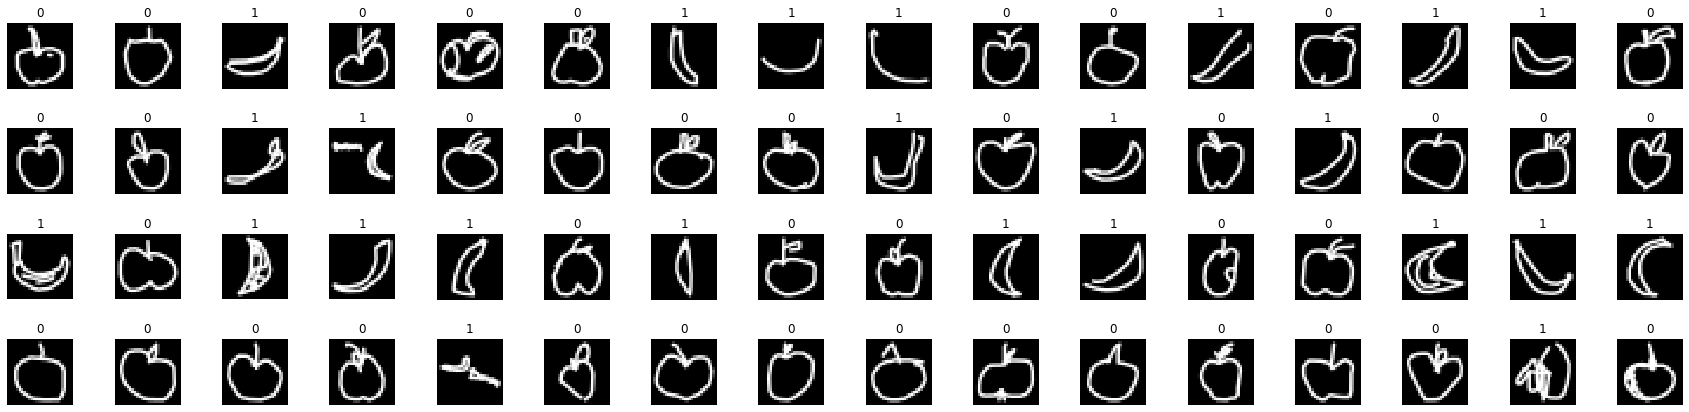

In [5]:
# Plot a few sketch examples
f, axarr = plt.subplots(4, 16, figsize=(24, 6))
f.tight_layout()

# Load a batch of images into memory
images, labels = next(iter(train_loader))

for i, ax in enumerate(axarr.flat):
    ax.imshow(images[i].view(28, 28), cmap="binary_r")
    ax.title.set_text(labels[i].item())
    ax.axis('off')
    
plt.show()

# VAE

In [0]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# VAE Conv

In [0]:
ngf = 16
ndf = 16
nc = 1
h_dim=1024

class conv_VAE(nn.Module):
    def __init__(self, nz=32):
        super(conv_VAE, self).__init__()
        
        self.nz = nz
        
        self.encoder = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 14 x 14
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 7 x 7
            nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1024, 4, 1, 0, bias=False),
            # nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Sigmoid()
        )
        
        
        self.decoder = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( 1024, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     nc, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(ngf),
            # nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            # nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            # nn.Tanh()
            nn.Sigmoid()
            # state size. (nc) x 64 x 64
        )
        
        self.fc1 = nn.Linear(1024, 512)
        self.fc21 = nn.Linear(512, nz)
        self.fc22 = nn.Linear(512, nz)

        self.fc3 = nn.Linear(nz, 512)
        self.fc4 = nn.Linear(512, 1024)

        self.lrelu = nn.LeakyReLU()
        self.relu = nn.ReLU()
        # self.sigmoid = nn.Sigmoid()
        
    def encode(self, x):
        conv = self.encoder(x);
        # print("encode conv", conv.size())
        h1 = self.fc1(conv.view(-1, 1024))
        # print("encode h1", h1.size())
        return self.fc21(h1), self.fc22(h1)

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        deconv_input = self.fc4(h3)
        # print("deconv_input", deconv_input.size())
        deconv_input = deconv_input.view(-1,1024,1,1)
        # print("deconv_input", deconv_input.size())
        return self.decoder(deconv_input)

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        # print("x", x.size())
        mu, logvar = self.encode(x)
        # print("mu, logvar", mu.size(), logvar.size())
        z = self.reparametrize(mu, logvar)
        # print("z", z.size())
        decoded = self.decode(z)
        # print("decoded", decoded.size())
        return decoded, mu, logvar

# Loss function

In [0]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl = -0.5 * torch.sum(1 + logvar - mu**2 - torch.exp(logvar), dim=1)

    return BCE + KLD, kl.mean()
    # return BCE + KLD, BCE, kl.mean()


# Train

In [0]:
def train(epoch):
    model.train()
    batch_loss, batch_kl = [],[]
    batch_idx = 0
    # batch_elbo = []

    for data, _ in train_loader:
        data = data.to(device)

        recon_batch, mu, logvar = model(data)
        loss, kld = loss_function(recon_batch, data, mu, logvar)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_loss.append(loss.item() / len(data)) # divide by batch_size to get average
        batch_kl.append(kld.item())

        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')   
        batch_idx = batch_idx + 1

    epoch_kl_train.append(np.mean(batch_kl))
    epoch_loss_train.append(np.mean(batch_loss))
    print(f'====> Epoch: {epoch} Average loss: {np.mean(batch_loss):.4f}')


# Test

In [0]:
def test(epoch):
    show_img = True
    datapath = os.path.join(root, 'results')
    if not os.path.exists(datapath):
        os.makedirs(datapath)
    
    model.eval()
    batch_loss, batch_kl = [],[]
    
    with torch.no_grad():
        for data, _ in test_loader: 
            data = data.to(device)

            recon_batch, mu, logvar = model(data)
            loss, kld = loss_function(recon_batch, data, mu, logvar)

            batch_loss.append(loss.item() / len(data))
            batch_kl.append(kld.item())
     
            recon_batch = recon_batch.to("cpu")

            if show_img:
                plot_all_images(data, recon_batch, 32)
                show_img = False

    epoch_kl_test.append(np.mean(batch_kl))
    epoch_loss_test.append(np.mean(batch_loss))
    print(f'====> Test set loss: {np.mean(batch_loss):.4f}')

# Plots

In [10]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid.inset_locator import inset_axes

# Plots the input, reconstructions, and latent space samples for 
def plot_all_images(data, recon_batch, bottleneck_dim):

    f, axarr = plt.subplots(1, 3, figsize=(24, 8))
    rows = 8
    columns = batch_size // rows

    # -- Inputs -- 
    ax = axarr[0]
    ax.set_title('Inputs')
    ax.axis('off')

    canvas = np.zeros((28*rows, columns*28))
    for i in range(rows):
        for j in range(columns):
            idx = i % columns + rows * j
            canvas[i*28:(i+1)*28, j*28:(j+1)*28] = data[idx].cpu().reshape((28, 28))
    ax.imshow(canvas, cmap='gray')

    # -- Reconstructions -- 
    ax = axarr[1]
    ax.set_title('Reconstructions')
    ax.axis('off')

    canvas = np.zeros((28*rows, columns*28))
    for i in range(rows):
        for j in range(columns):
            idx = i % columns + rows * j
            canvas[i*28:(i+1)*28, j*28:(j+1)*28] = recon_batch[idx].cpu().reshape((28, 28))
    ax.imshow(canvas, cmap='gray')

    # -- Latent space samples --
    ax = axarr[2]
    ax.set_title('Latent Space Samples')
    ax.axis('off')

    with torch.no_grad():
        epsilon = torch.randn(64, bottleneck_dim).to(device)
        samples = model.decode(epsilon).cpu()

    canvas = np.zeros((28*rows, columns*28))
    for i in range(rows):
        for j in range(columns):
            idx = i % columns + rows * j
            canvas[i*28:(i+1)*28, j*28:(j+1)*28] = samples[idx].reshape((28, 28))
    ax.imshow(canvas, cmap='gray')

    plt.show()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  


In [0]:
def plot_losses(epoch_list, train_loss_all, test_loss_all, kl_loss_train, kl_loss_test):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))
    
    # ELBO loss
    ax1.set_title("ELBO loss")
    ax1.plot(epoch_list, train_loss_all, color="blue")
    ax1.plot(epoch_list, test_loss_all, color="green", linestyle="--")
    ax1.legend(['Training', 'Testing'])
    ax1.set(xlabel='epochs', ylabel='loss')

    # KL loss
    ax2.set_title("KL loss")
    ax2.plot(epoch_list, kl_loss_train, color="blue")
    ax2.plot(epoch_list, kl_loss_test, color="green", linestyle="--")
    ax2.legend(['Training', 'Testing'])
    ax2.set(xlabel='epochs', ylabel='loss')
    
    plt.show()

In [0]:

def plot_interpolated_images(images):

    f, axarr = plt.subplots(1, images.shape[0], figsize=(20, 5))
    f.tight_layout()

    for i, ax in enumerate(axarr.flat):
        ax.imshow(images[i].view(28, 28), cmap="binary_r")
        ax.axis('off')
    plt.show()

# Main

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Using a target size (torch.Size([64, 784])) that is different to the input size (torch.Size([64, 1, 28, 28])) is deprecated. Please ensure they have the same size.
  


Train Epoch: 1 [0/16000 (0%)]	Loss: 709.066101
Train Epoch: 1 [1024/16000 (6%)]	Loss: 347.782440
Train Epoch: 1 [2048/16000 (13%)]	Loss: 293.490967
Train Epoch: 1 [3072/16000 (19%)]	Loss: 279.008331
Train Epoch: 1 [4096/16000 (26%)]	Loss: 277.478516
Train Epoch: 1 [5120/16000 (32%)]	Loss: 259.910187
Train Epoch: 1 [6144/16000 (38%)]	Loss: 257.029724
Train Epoch: 1 [7168/16000 (45%)]	Loss: 250.260681
Train Epoch: 1 [8192/16000 (51%)]	Loss: 240.978912
Train Epoch: 1 [9216/16000 (58%)]	Loss: 234.850525
Train Epoch: 1 [10240/16000 (64%)]	Loss: 229.395920
Train Epoch: 1 [11264/16000 (70%)]	Loss: 216.053131
Train Epoch: 1 [12288/16000 (77%)]	Loss: 219.483734
Train Epoch: 1 [13312/16000 (83%)]	Loss: 206.034805
Train Epoch: 1 [14336/16000 (90%)]	Loss: 205.885864
Train Epoch: 1 [15360/16000 (96%)]	Loss: 208.021118
====> Epoch: 1 Average loss: 261.4677


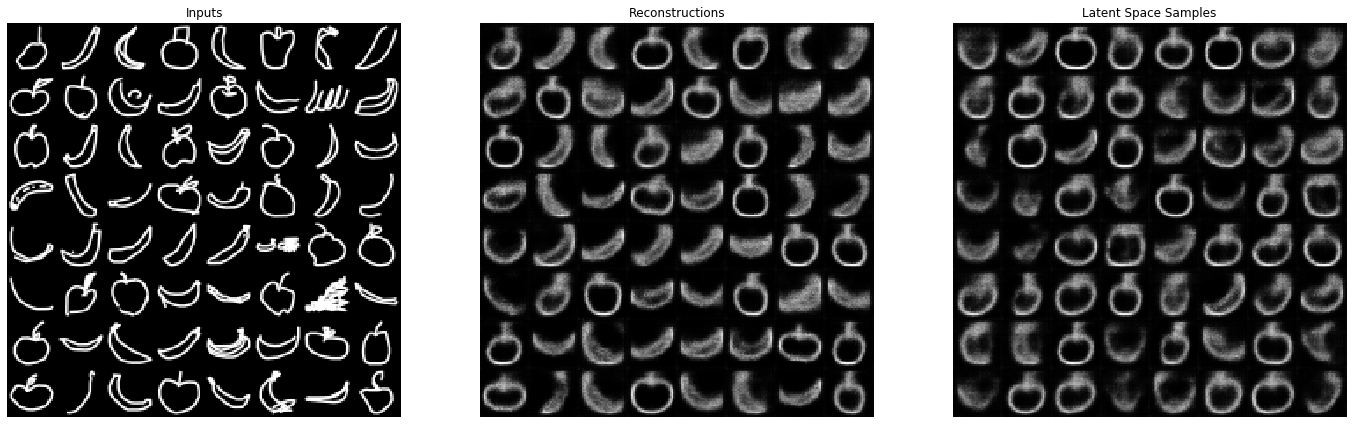

====> Test set loss: 204.6767
Train Epoch: 2 [0/16000 (0%)]	Loss: 207.710266
Train Epoch: 2 [1024/16000 (6%)]	Loss: 195.664383
Train Epoch: 2 [2048/16000 (13%)]	Loss: 198.847092
Train Epoch: 2 [3072/16000 (19%)]	Loss: 196.462631
Train Epoch: 2 [4096/16000 (26%)]	Loss: 196.276596
Train Epoch: 2 [5120/16000 (32%)]	Loss: 186.662186
Train Epoch: 2 [6144/16000 (38%)]	Loss: 198.083588
Train Epoch: 2 [7168/16000 (45%)]	Loss: 186.038055
Train Epoch: 2 [8192/16000 (51%)]	Loss: 196.817749
Train Epoch: 2 [9216/16000 (58%)]	Loss: 177.838913
Train Epoch: 2 [10240/16000 (64%)]	Loss: 173.307770
Train Epoch: 2 [11264/16000 (70%)]	Loss: 184.079315
Train Epoch: 2 [12288/16000 (77%)]	Loss: 181.345932
Train Epoch: 2 [13312/16000 (83%)]	Loss: 180.338623
Train Epoch: 2 [14336/16000 (90%)]	Loss: 178.992828
Train Epoch: 2 [15360/16000 (96%)]	Loss: 186.050079
====> Epoch: 2 Average loss: 188.5525


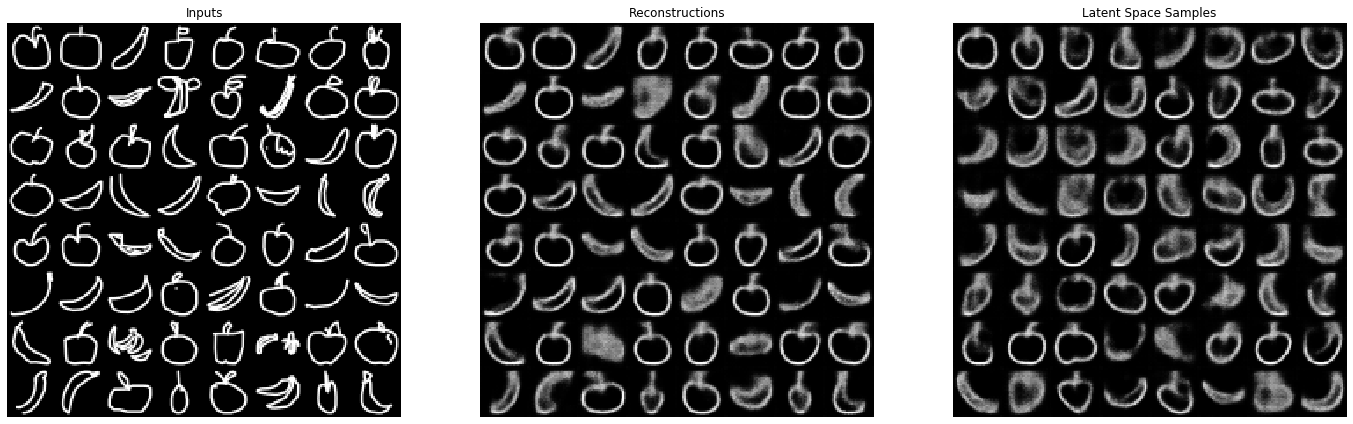

====> Test set loss: 177.8462


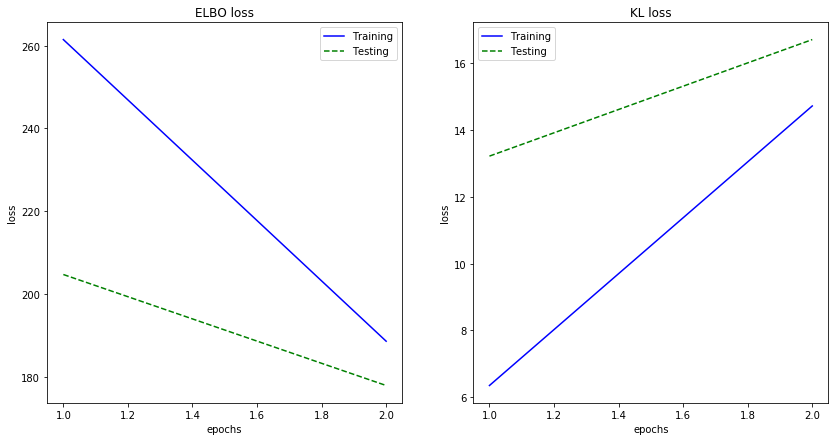

################################################################
Train Epoch: 3 [0/16000 (0%)]	Loss: 183.399963
Train Epoch: 3 [1024/16000 (6%)]	Loss: 185.686325
Train Epoch: 3 [2048/16000 (13%)]	Loss: 186.792114
Train Epoch: 3 [3072/16000 (19%)]	Loss: 170.761566
Train Epoch: 3 [4096/16000 (26%)]	Loss: 174.141037
Train Epoch: 3 [5120/16000 (32%)]	Loss: 176.028946
Train Epoch: 3 [6144/16000 (38%)]	Loss: 176.449463
Train Epoch: 3 [7168/16000 (45%)]	Loss: 163.600662
Train Epoch: 3 [8192/16000 (51%)]	Loss: 175.867325
Train Epoch: 3 [9216/16000 (58%)]	Loss: 169.138596
Train Epoch: 3 [10240/16000 (64%)]	Loss: 165.608734
Train Epoch: 3 [11264/16000 (70%)]	Loss: 176.038330
Train Epoch: 3 [12288/16000 (77%)]	Loss: 179.109924
Train Epoch: 3 [13312/16000 (83%)]	Loss: 173.164825
Train Epoch: 3 [14336/16000 (90%)]	Loss: 163.083893
Train Epoch: 3 [15360/16000 (96%)]	Loss: 175.918854
====> Epoch: 3 Average loss: 173.5843


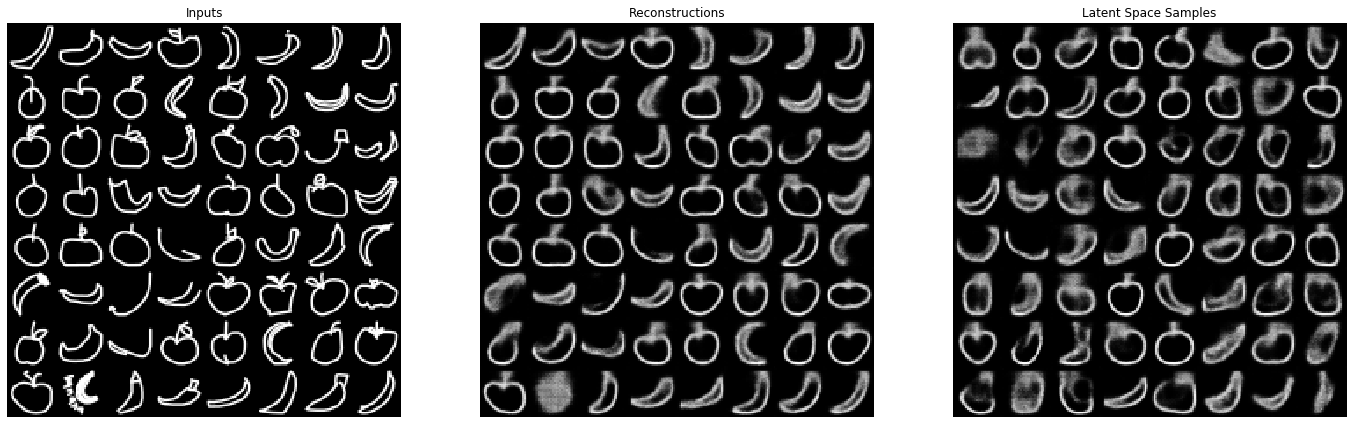

====> Test set loss: 171.8288


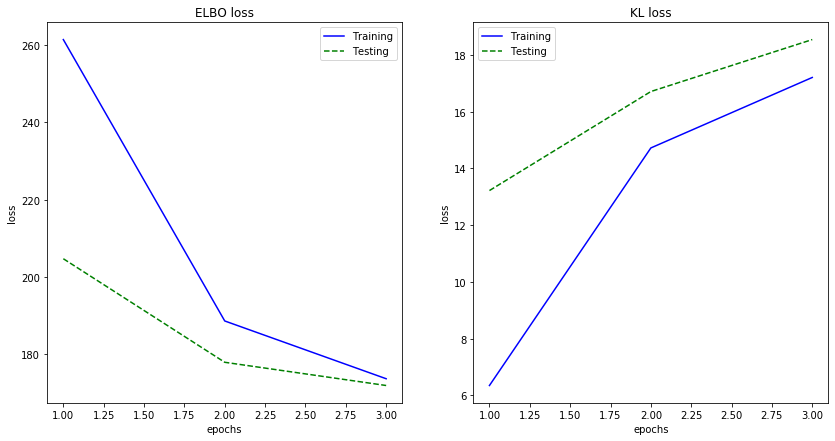

################################################################
Train Epoch: 4 [0/16000 (0%)]	Loss: 172.267273
Train Epoch: 4 [1024/16000 (6%)]	Loss: 167.024445
Train Epoch: 4 [2048/16000 (13%)]	Loss: 167.080444
Train Epoch: 4 [3072/16000 (19%)]	Loss: 161.391510
Train Epoch: 4 [4096/16000 (26%)]	Loss: 166.577423
Train Epoch: 4 [5120/16000 (32%)]	Loss: 168.795883
Train Epoch: 4 [6144/16000 (38%)]	Loss: 164.442474
Train Epoch: 4 [7168/16000 (45%)]	Loss: 164.691986
Train Epoch: 4 [8192/16000 (51%)]	Loss: 173.399994
Train Epoch: 4 [9216/16000 (58%)]	Loss: 164.576843
Train Epoch: 4 [10240/16000 (64%)]	Loss: 166.022598
Train Epoch: 4 [11264/16000 (70%)]	Loss: 163.777740
Train Epoch: 4 [12288/16000 (77%)]	Loss: 162.705841
Train Epoch: 4 [13312/16000 (83%)]	Loss: 172.169952
Train Epoch: 4 [14336/16000 (90%)]	Loss: 165.369781
Train Epoch: 4 [15360/16000 (96%)]	Loss: 160.810181
====> Epoch: 4 Average loss: 166.2575


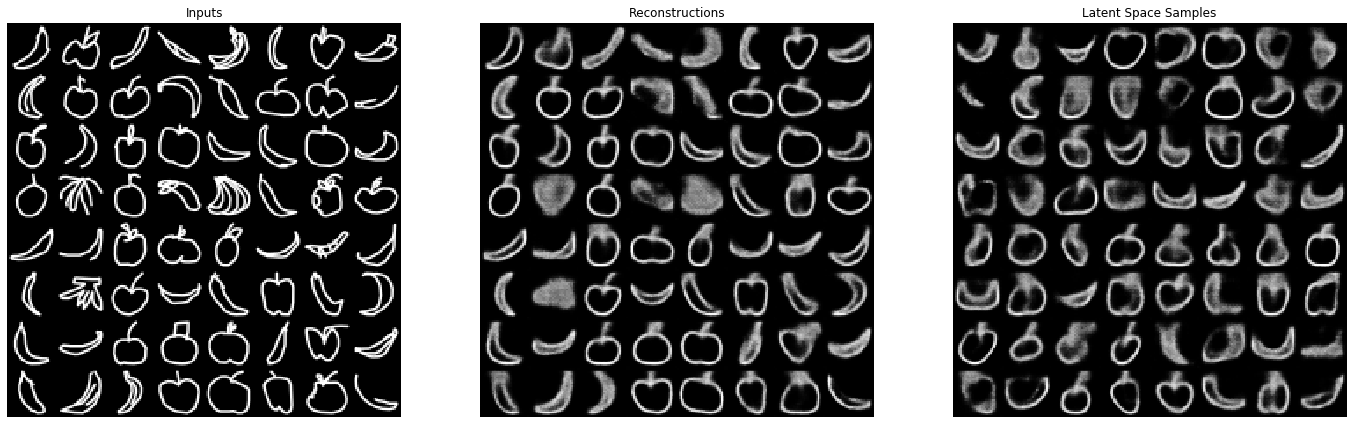

====> Test set loss: 166.8438


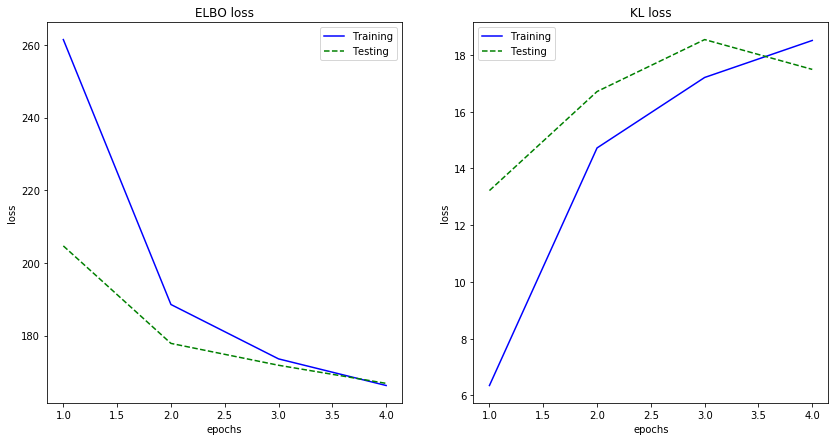

################################################################
Train Epoch: 5 [0/16000 (0%)]	Loss: 161.778488
Train Epoch: 5 [1024/16000 (6%)]	Loss: 156.020508
Train Epoch: 5 [2048/16000 (13%)]	Loss: 167.918808
Train Epoch: 5 [3072/16000 (19%)]	Loss: 166.187317
Train Epoch: 5 [4096/16000 (26%)]	Loss: 166.773758
Train Epoch: 5 [5120/16000 (32%)]	Loss: 159.308868
Train Epoch: 5 [6144/16000 (38%)]	Loss: 162.792313
Train Epoch: 5 [7168/16000 (45%)]	Loss: 166.303741
Train Epoch: 5 [8192/16000 (51%)]	Loss: 168.708847
Train Epoch: 5 [9216/16000 (58%)]	Loss: 163.414398
Train Epoch: 5 [10240/16000 (64%)]	Loss: 161.652634
Train Epoch: 5 [11264/16000 (70%)]	Loss: 161.716629
Train Epoch: 5 [12288/16000 (77%)]	Loss: 165.554016
Train Epoch: 5 [13312/16000 (83%)]	Loss: 158.916977
Train Epoch: 5 [14336/16000 (90%)]	Loss: 164.838928
Train Epoch: 5 [15360/16000 (96%)]	Loss: 161.418839
====> Epoch: 5 Average loss: 162.4946


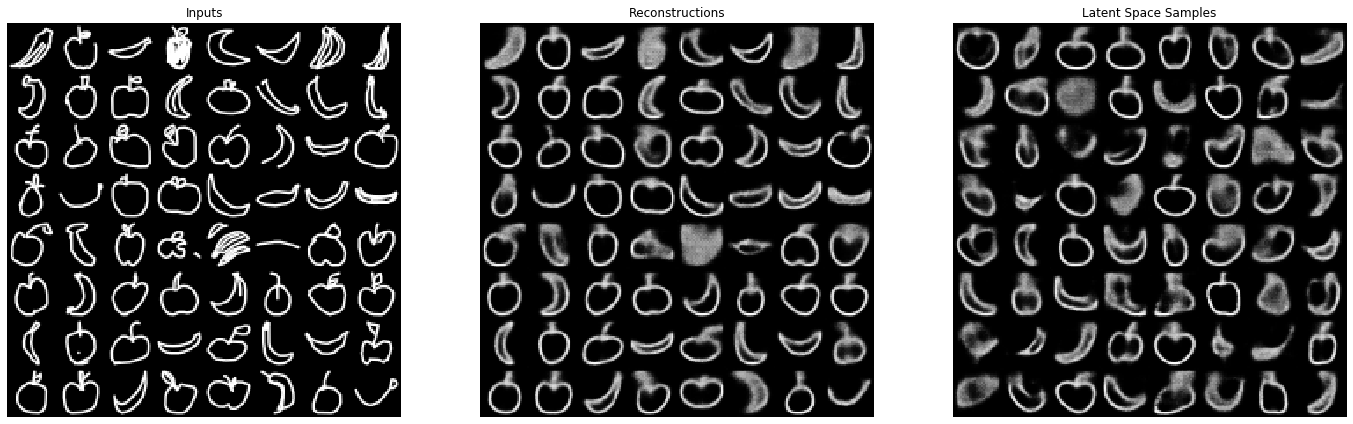

====> Test set loss: 164.6754


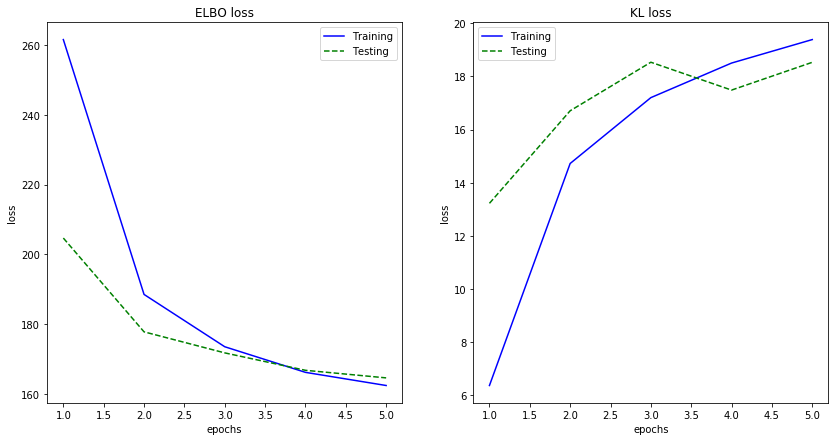

################################################################
Train Epoch: 6 [0/16000 (0%)]	Loss: 158.753448
Train Epoch: 6 [1024/16000 (6%)]	Loss: 156.878601
Train Epoch: 6 [2048/16000 (13%)]	Loss: 160.054291
Train Epoch: 6 [3072/16000 (19%)]	Loss: 154.833084
Train Epoch: 6 [4096/16000 (26%)]	Loss: 158.467773
Train Epoch: 6 [5120/16000 (32%)]	Loss: 159.512054
Train Epoch: 6 [6144/16000 (38%)]	Loss: 157.740524
Train Epoch: 6 [7168/16000 (45%)]	Loss: 173.250732
Train Epoch: 6 [8192/16000 (51%)]	Loss: 161.380920
Train Epoch: 6 [9216/16000 (58%)]	Loss: 160.750732
Train Epoch: 6 [10240/16000 (64%)]	Loss: 148.020721
Train Epoch: 6 [11264/16000 (70%)]	Loss: 167.365891
Train Epoch: 6 [12288/16000 (77%)]	Loss: 157.072601
Train Epoch: 6 [13312/16000 (83%)]	Loss: 166.793304
Train Epoch: 6 [14336/16000 (90%)]	Loss: 162.162476
Train Epoch: 6 [15360/16000 (96%)]	Loss: 161.384872
====> Epoch: 6 Average loss: 159.5121


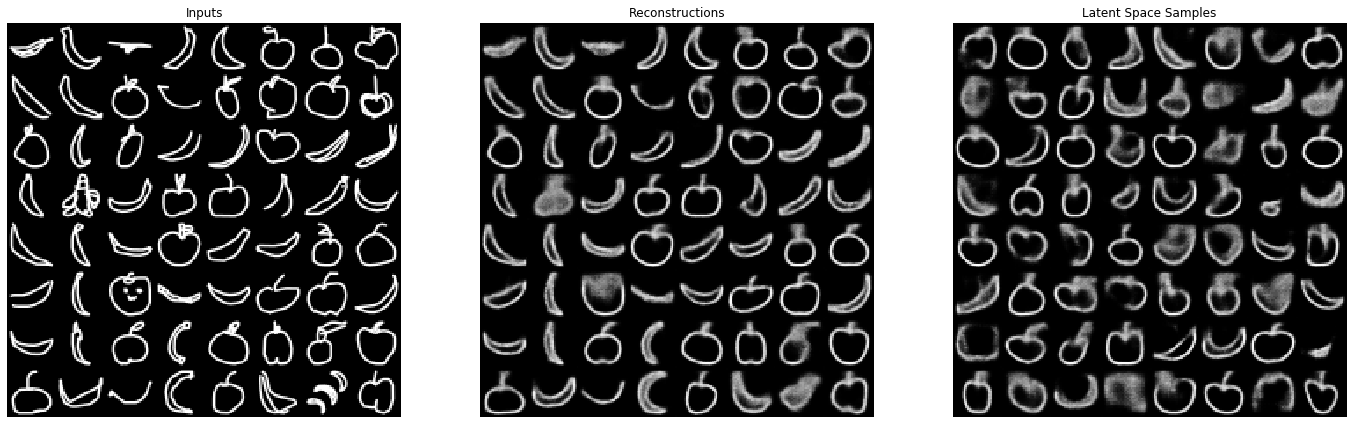

====> Test set loss: 159.5954


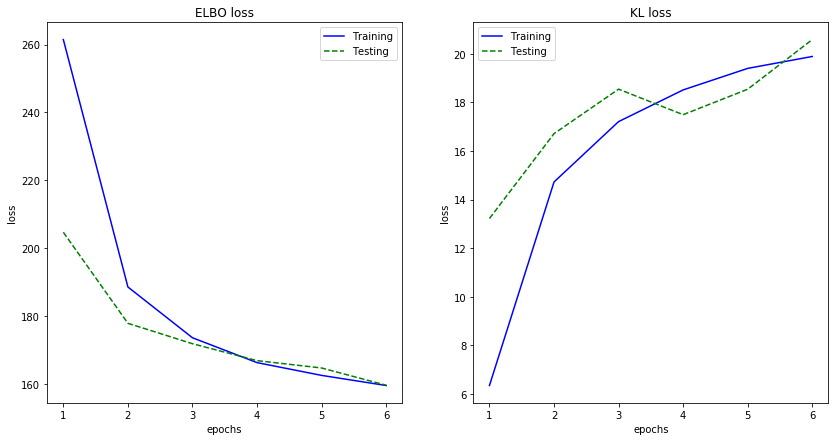

################################################################
Train Epoch: 7 [0/16000 (0%)]	Loss: 157.085800
Train Epoch: 7 [1024/16000 (6%)]	Loss: 159.110855
Train Epoch: 7 [2048/16000 (13%)]	Loss: 155.677612
Train Epoch: 7 [3072/16000 (19%)]	Loss: 156.650528
Train Epoch: 7 [4096/16000 (26%)]	Loss: 160.376678
Train Epoch: 7 [5120/16000 (32%)]	Loss: 163.164536
Train Epoch: 7 [6144/16000 (38%)]	Loss: 156.749481
Train Epoch: 7 [7168/16000 (45%)]	Loss: 158.867554
Train Epoch: 7 [8192/16000 (51%)]	Loss: 157.112946
Train Epoch: 7 [9216/16000 (58%)]	Loss: 159.153839
Train Epoch: 7 [10240/16000 (64%)]	Loss: 154.276093
Train Epoch: 7 [11264/16000 (70%)]	Loss: 154.928131
Train Epoch: 7 [12288/16000 (77%)]	Loss: 153.663132
Train Epoch: 7 [13312/16000 (83%)]	Loss: 151.709076
Train Epoch: 7 [14336/16000 (90%)]	Loss: 155.184250
Train Epoch: 7 [15360/16000 (96%)]	Loss: 159.302994
====> Epoch: 7 Average loss: 157.1130


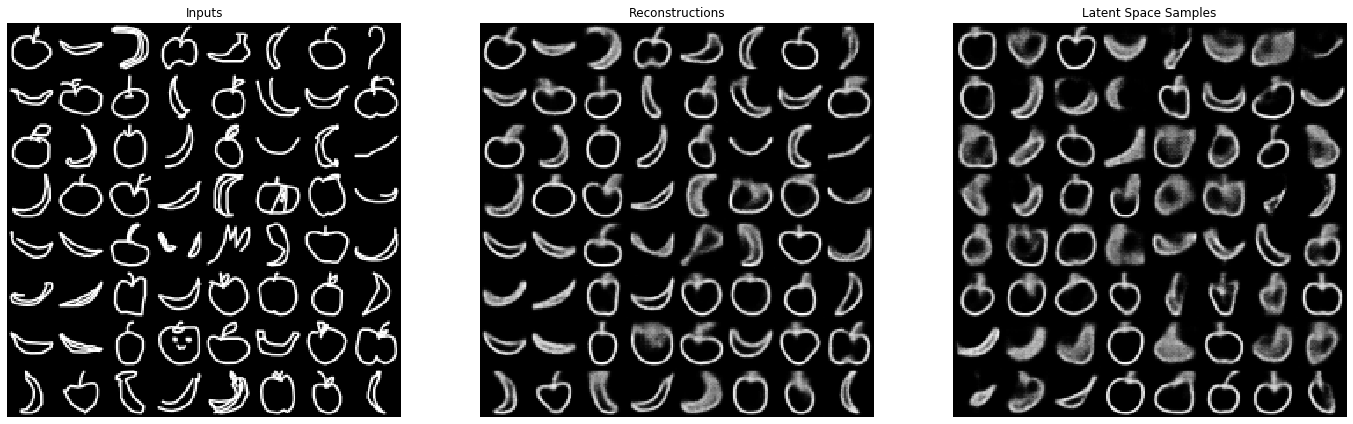

====> Test set loss: 158.4177


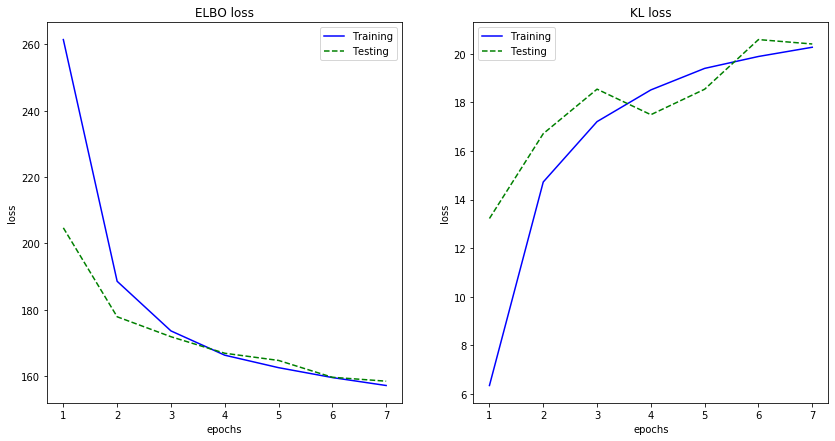

################################################################
Train Epoch: 8 [0/16000 (0%)]	Loss: 159.535187
Train Epoch: 8 [1024/16000 (6%)]	Loss: 143.786026
Train Epoch: 8 [2048/16000 (13%)]	Loss: 155.650909
Train Epoch: 8 [3072/16000 (19%)]	Loss: 157.213425
Train Epoch: 8 [4096/16000 (26%)]	Loss: 158.705872
Train Epoch: 8 [5120/16000 (32%)]	Loss: 149.307434
Train Epoch: 8 [6144/16000 (38%)]	Loss: 160.546082
Train Epoch: 8 [7168/16000 (45%)]	Loss: 154.833710
Train Epoch: 8 [8192/16000 (51%)]	Loss: 155.426468
Train Epoch: 8 [9216/16000 (58%)]	Loss: 161.304474
Train Epoch: 8 [10240/16000 (64%)]	Loss: 154.881088
Train Epoch: 8 [11264/16000 (70%)]	Loss: 144.120560
Train Epoch: 8 [12288/16000 (77%)]	Loss: 159.738586
Train Epoch: 8 [13312/16000 (83%)]	Loss: 155.215332
Train Epoch: 8 [14336/16000 (90%)]	Loss: 154.034836
Train Epoch: 8 [15360/16000 (96%)]	Loss: 153.566986
====> Epoch: 8 Average loss: 155.5322


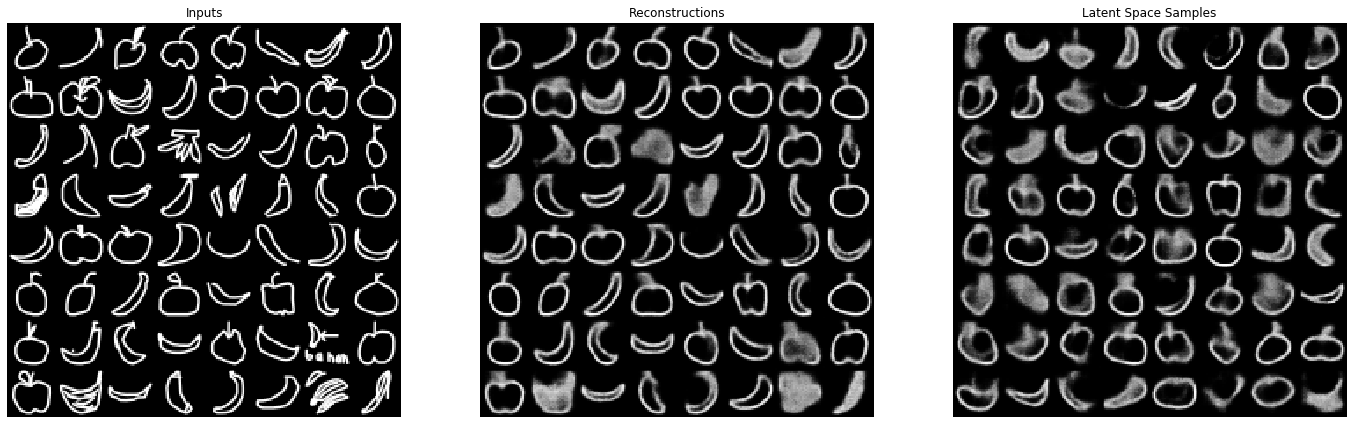

====> Test set loss: 157.4434


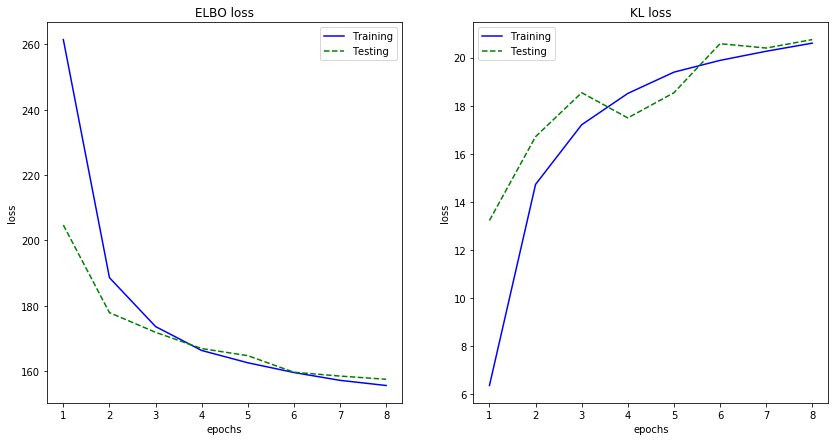

################################################################
Train Epoch: 9 [0/16000 (0%)]	Loss: 161.299545
Train Epoch: 9 [1024/16000 (6%)]	Loss: 159.057922
Train Epoch: 9 [2048/16000 (13%)]	Loss: 164.278656
Train Epoch: 9 [3072/16000 (19%)]	Loss: 154.768753
Train Epoch: 9 [4096/16000 (26%)]	Loss: 149.490707
Train Epoch: 9 [5120/16000 (32%)]	Loss: 157.721313
Train Epoch: 9 [6144/16000 (38%)]	Loss: 158.253387
Train Epoch: 9 [7168/16000 (45%)]	Loss: 151.653519
Train Epoch: 9 [8192/16000 (51%)]	Loss: 160.282440
Train Epoch: 9 [9216/16000 (58%)]	Loss: 150.695206
Train Epoch: 9 [10240/16000 (64%)]	Loss: 155.729675
Train Epoch: 9 [11264/16000 (70%)]	Loss: 160.942459
Train Epoch: 9 [12288/16000 (77%)]	Loss: 155.436707
Train Epoch: 9 [13312/16000 (83%)]	Loss: 152.538437
Train Epoch: 9 [14336/16000 (90%)]	Loss: 146.542099
Train Epoch: 9 [15360/16000 (96%)]	Loss: 157.162613
====> Epoch: 9 Average loss: 154.0767


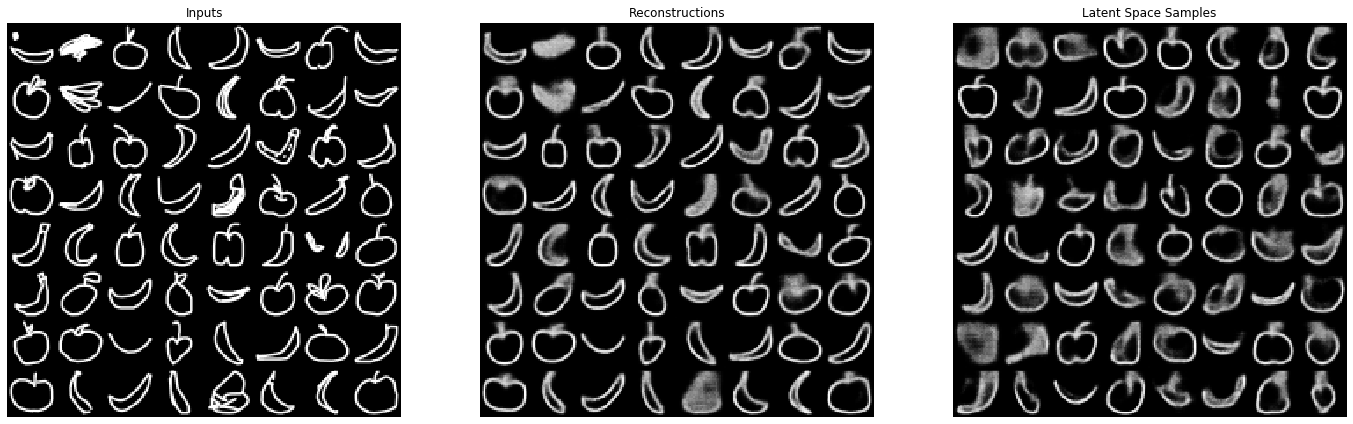

====> Test set loss: 157.4739


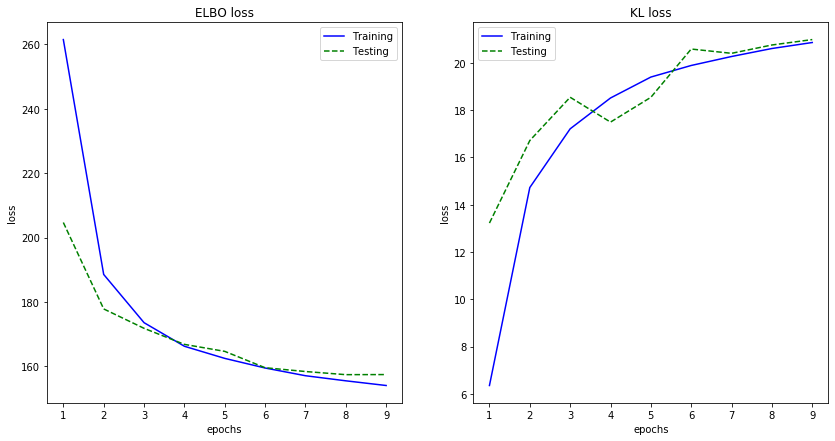

################################################################
Train Epoch: 10 [0/16000 (0%)]	Loss: 148.880432
Train Epoch: 10 [1024/16000 (6%)]	Loss: 157.908234
Train Epoch: 10 [2048/16000 (13%)]	Loss: 151.418655
Train Epoch: 10 [3072/16000 (19%)]	Loss: 150.728195
Train Epoch: 10 [4096/16000 (26%)]	Loss: 161.693649
Train Epoch: 10 [5120/16000 (32%)]	Loss: 155.914520
Train Epoch: 10 [6144/16000 (38%)]	Loss: 154.209976
Train Epoch: 10 [7168/16000 (45%)]	Loss: 146.127975
Train Epoch: 10 [8192/16000 (51%)]	Loss: 146.037460
Train Epoch: 10 [9216/16000 (58%)]	Loss: 152.918457
Train Epoch: 10 [10240/16000 (64%)]	Loss: 150.447632
Train Epoch: 10 [11264/16000 (70%)]	Loss: 154.928436
Train Epoch: 10 [12288/16000 (77%)]	Loss: 159.252838
Train Epoch: 10 [13312/16000 (83%)]	Loss: 151.020065
Train Epoch: 10 [14336/16000 (90%)]	Loss: 148.005035
Train Epoch: 10 [15360/16000 (96%)]	Loss: 146.071030
====> Epoch: 10 Average loss: 152.6663


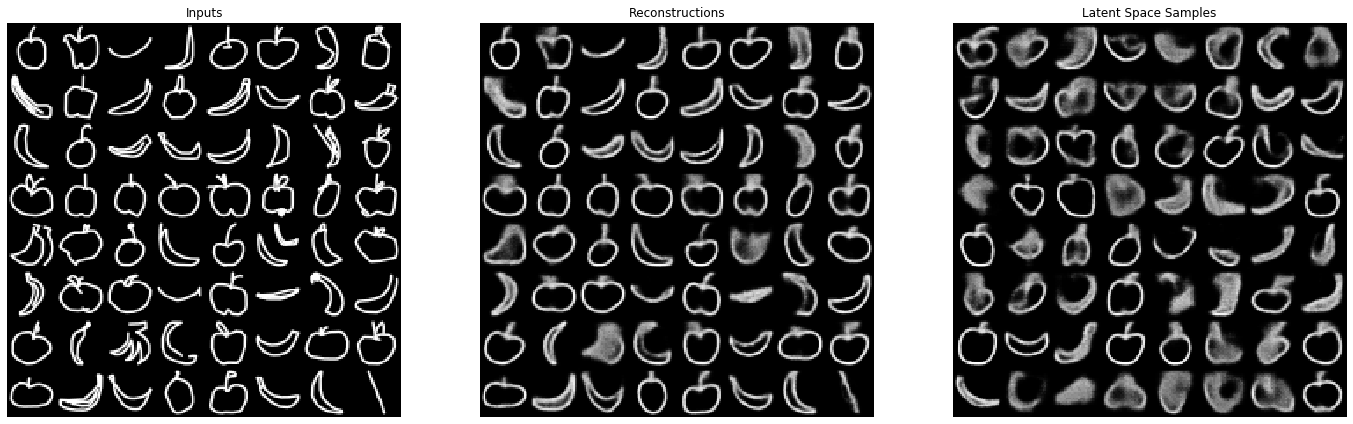

====> Test set loss: 157.8050


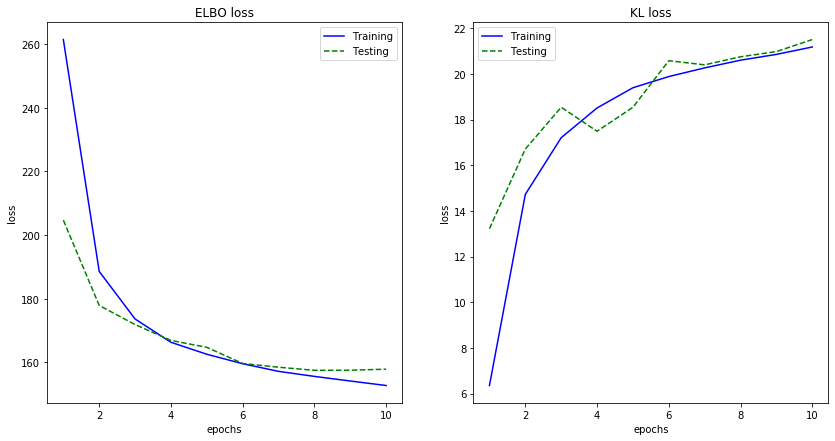

################################################################
Train Epoch: 11 [0/16000 (0%)]	Loss: 153.341766
Train Epoch: 11 [1024/16000 (6%)]	Loss: 150.754990
Train Epoch: 11 [2048/16000 (13%)]	Loss: 150.875351
Train Epoch: 11 [3072/16000 (19%)]	Loss: 148.772171
Train Epoch: 11 [4096/16000 (26%)]	Loss: 153.216644
Train Epoch: 11 [5120/16000 (32%)]	Loss: 157.276031
Train Epoch: 11 [6144/16000 (38%)]	Loss: 150.318039
Train Epoch: 11 [7168/16000 (45%)]	Loss: 152.418671
Train Epoch: 11 [8192/16000 (51%)]	Loss: 147.750656
Train Epoch: 11 [9216/16000 (58%)]	Loss: 154.315460
Train Epoch: 11 [10240/16000 (64%)]	Loss: 154.393982
Train Epoch: 11 [11264/16000 (70%)]	Loss: 152.539276
Train Epoch: 11 [12288/16000 (77%)]	Loss: 143.740326
Train Epoch: 11 [13312/16000 (83%)]	Loss: 156.751221
Train Epoch: 11 [14336/16000 (90%)]	Loss: 154.207779
Train Epoch: 11 [15360/16000 (96%)]	Loss: 145.879089
====> Epoch: 11 Average loss: 151.8830


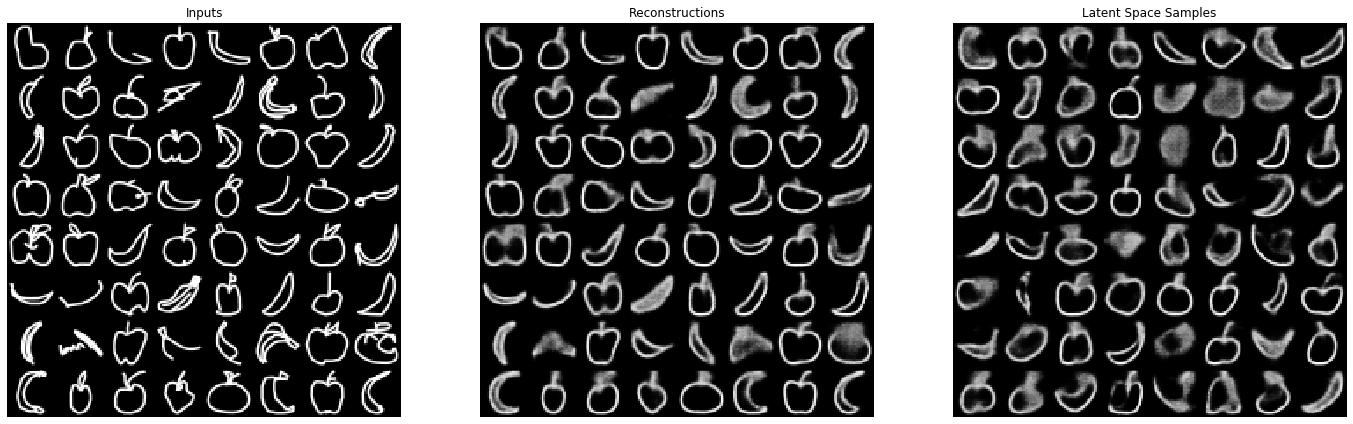

====> Test set loss: 153.4927


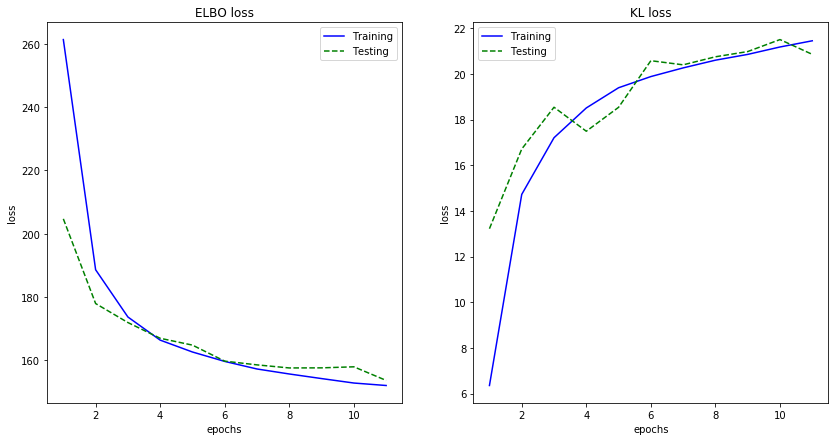

################################################################
Train Epoch: 12 [0/16000 (0%)]	Loss: 144.430084
Train Epoch: 12 [1024/16000 (6%)]	Loss: 142.885025
Train Epoch: 12 [2048/16000 (13%)]	Loss: 149.264740
Train Epoch: 12 [3072/16000 (19%)]	Loss: 147.648468
Train Epoch: 12 [4096/16000 (26%)]	Loss: 157.426620
Train Epoch: 12 [5120/16000 (32%)]	Loss: 151.598984
Train Epoch: 12 [6144/16000 (38%)]	Loss: 146.002960
Train Epoch: 12 [7168/16000 (45%)]	Loss: 150.611710
Train Epoch: 12 [8192/16000 (51%)]	Loss: 146.285187
Train Epoch: 12 [9216/16000 (58%)]	Loss: 161.385315
Train Epoch: 12 [10240/16000 (64%)]	Loss: 151.378494
Train Epoch: 12 [11264/16000 (70%)]	Loss: 148.547882
Train Epoch: 12 [12288/16000 (77%)]	Loss: 149.050232
Train Epoch: 12 [13312/16000 (83%)]	Loss: 145.144470
Train Epoch: 12 [14336/16000 (90%)]	Loss: 156.655029
Train Epoch: 12 [15360/16000 (96%)]	Loss: 148.915588
====> Epoch: 12 Average loss: 150.7922


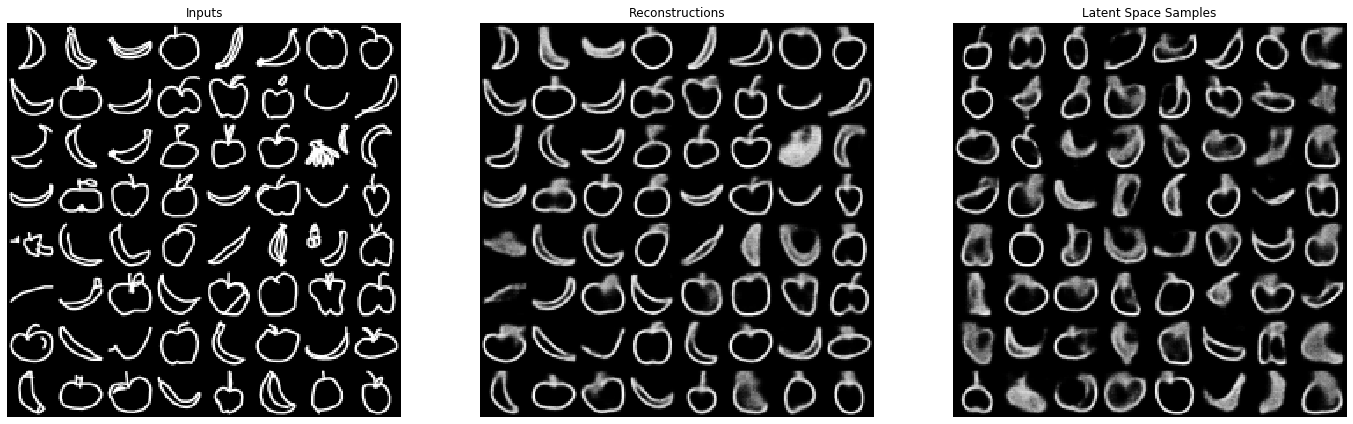

====> Test set loss: 152.8730


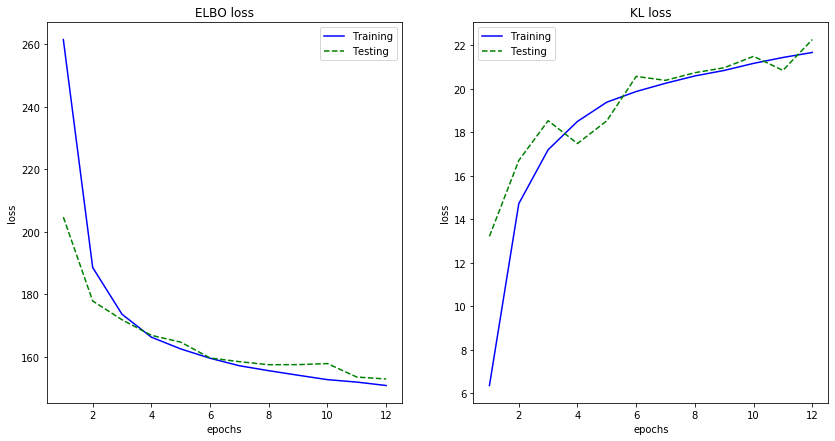

################################################################
Train Epoch: 13 [0/16000 (0%)]	Loss: 146.800613
Train Epoch: 13 [1024/16000 (6%)]	Loss: 148.617950
Train Epoch: 13 [2048/16000 (13%)]	Loss: 150.653793
Train Epoch: 13 [3072/16000 (19%)]	Loss: 152.861115
Train Epoch: 13 [4096/16000 (26%)]	Loss: 152.938370
Train Epoch: 13 [5120/16000 (32%)]	Loss: 148.522003
Train Epoch: 13 [6144/16000 (38%)]	Loss: 141.962524
Train Epoch: 13 [7168/16000 (45%)]	Loss: 146.906113
Train Epoch: 13 [8192/16000 (51%)]	Loss: 154.269714
Train Epoch: 13 [9216/16000 (58%)]	Loss: 156.559784
Train Epoch: 13 [10240/16000 (64%)]	Loss: 148.739120
Train Epoch: 13 [11264/16000 (70%)]	Loss: 150.237381
Train Epoch: 13 [12288/16000 (77%)]	Loss: 152.130051
Train Epoch: 13 [13312/16000 (83%)]	Loss: 145.360413
Train Epoch: 13 [14336/16000 (90%)]	Loss: 150.931824
Train Epoch: 13 [15360/16000 (96%)]	Loss: 143.859711
====> Epoch: 13 Average loss: 149.9713


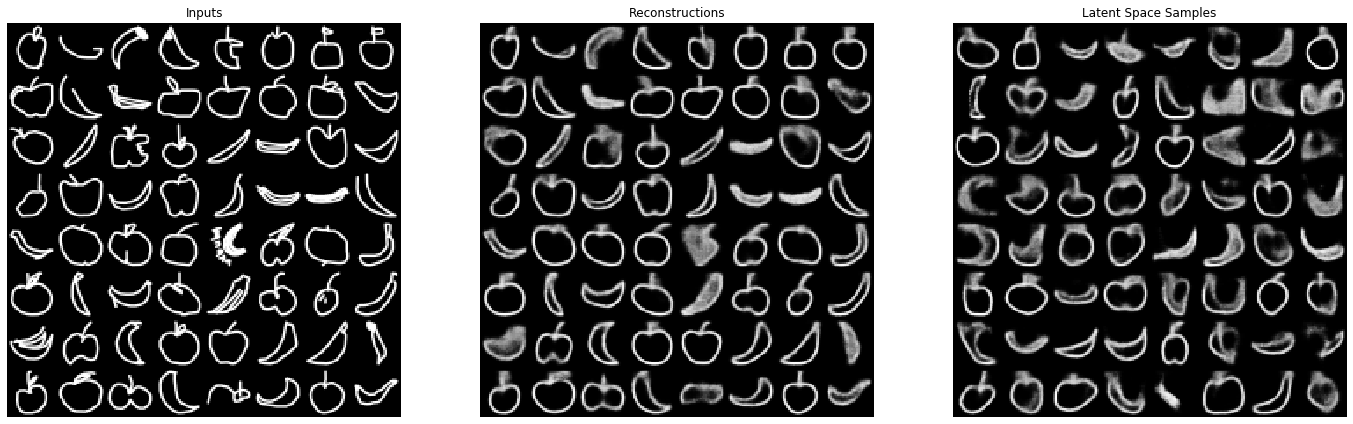

====> Test set loss: 153.0238


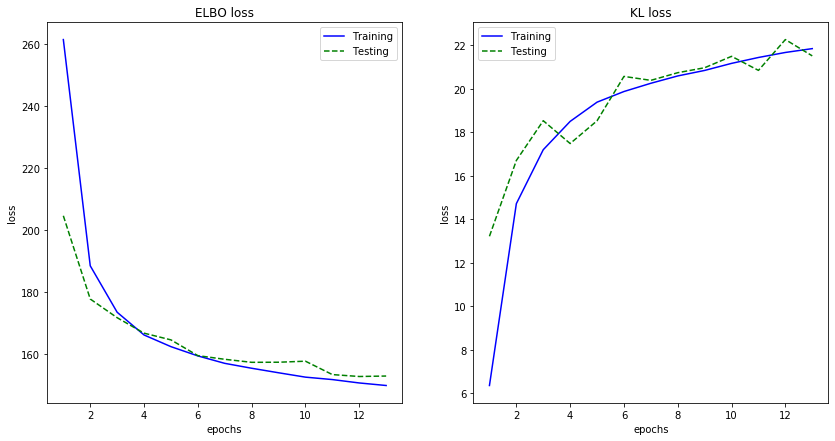

################################################################
Train Epoch: 14 [0/16000 (0%)]	Loss: 152.295990
Train Epoch: 14 [1024/16000 (6%)]	Loss: 142.974533
Train Epoch: 14 [2048/16000 (13%)]	Loss: 140.504150
Train Epoch: 14 [3072/16000 (19%)]	Loss: 151.583649
Train Epoch: 14 [4096/16000 (26%)]	Loss: 157.049454
Train Epoch: 14 [5120/16000 (32%)]	Loss: 152.604782
Train Epoch: 14 [6144/16000 (38%)]	Loss: 150.972076
Train Epoch: 14 [7168/16000 (45%)]	Loss: 147.827026
Train Epoch: 14 [8192/16000 (51%)]	Loss: 147.384216
Train Epoch: 14 [9216/16000 (58%)]	Loss: 149.881638
Train Epoch: 14 [10240/16000 (64%)]	Loss: 150.782745
Train Epoch: 14 [11264/16000 (70%)]	Loss: 149.849228
Train Epoch: 14 [12288/16000 (77%)]	Loss: 149.971909
Train Epoch: 14 [13312/16000 (83%)]	Loss: 153.133957
Train Epoch: 14 [14336/16000 (90%)]	Loss: 148.603607
Train Epoch: 14 [15360/16000 (96%)]	Loss: 144.397278
====> Epoch: 14 Average loss: 149.0559


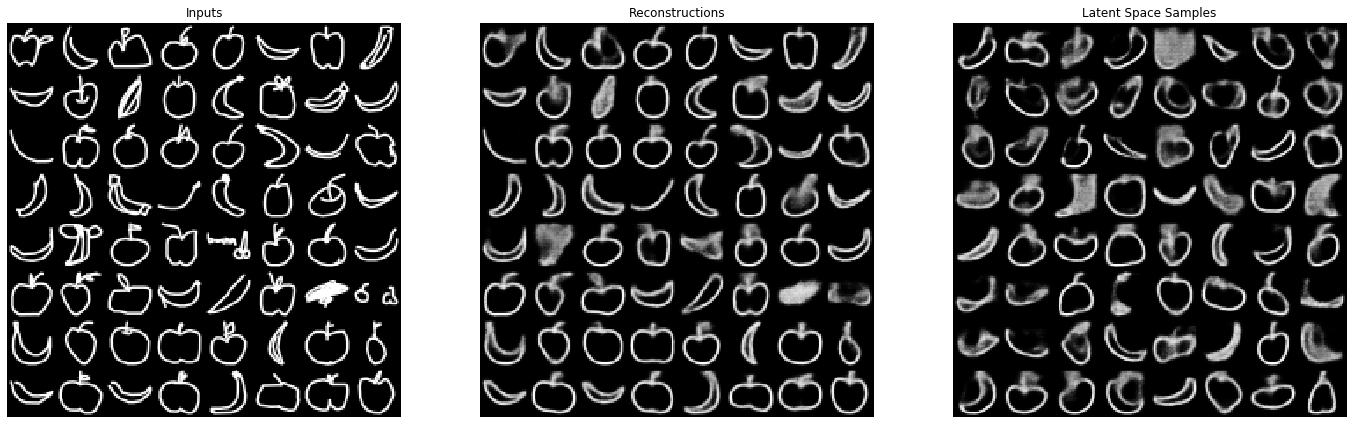

====> Test set loss: 151.7548


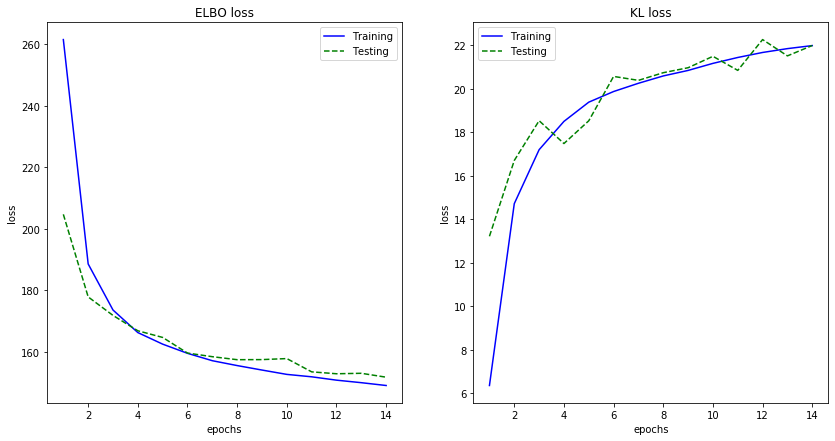

################################################################
Train Epoch: 15 [0/16000 (0%)]	Loss: 146.999359
Train Epoch: 15 [1024/16000 (6%)]	Loss: 152.010895
Train Epoch: 15 [2048/16000 (13%)]	Loss: 149.271179
Train Epoch: 15 [3072/16000 (19%)]	Loss: 147.584946
Train Epoch: 15 [4096/16000 (26%)]	Loss: 147.416397
Train Epoch: 15 [5120/16000 (32%)]	Loss: 143.661102
Train Epoch: 15 [6144/16000 (38%)]	Loss: 147.641266
Train Epoch: 15 [7168/16000 (45%)]	Loss: 152.936768
Train Epoch: 15 [8192/16000 (51%)]	Loss: 154.506256
Train Epoch: 15 [9216/16000 (58%)]	Loss: 151.634094
Train Epoch: 15 [10240/16000 (64%)]	Loss: 146.425156
Train Epoch: 15 [11264/16000 (70%)]	Loss: 152.399384
Train Epoch: 15 [12288/16000 (77%)]	Loss: 148.513458
Train Epoch: 15 [13312/16000 (83%)]	Loss: 150.438065
Train Epoch: 15 [14336/16000 (90%)]	Loss: 145.319656
Train Epoch: 15 [15360/16000 (96%)]	Loss: 141.216034
====> Epoch: 15 Average loss: 148.1772


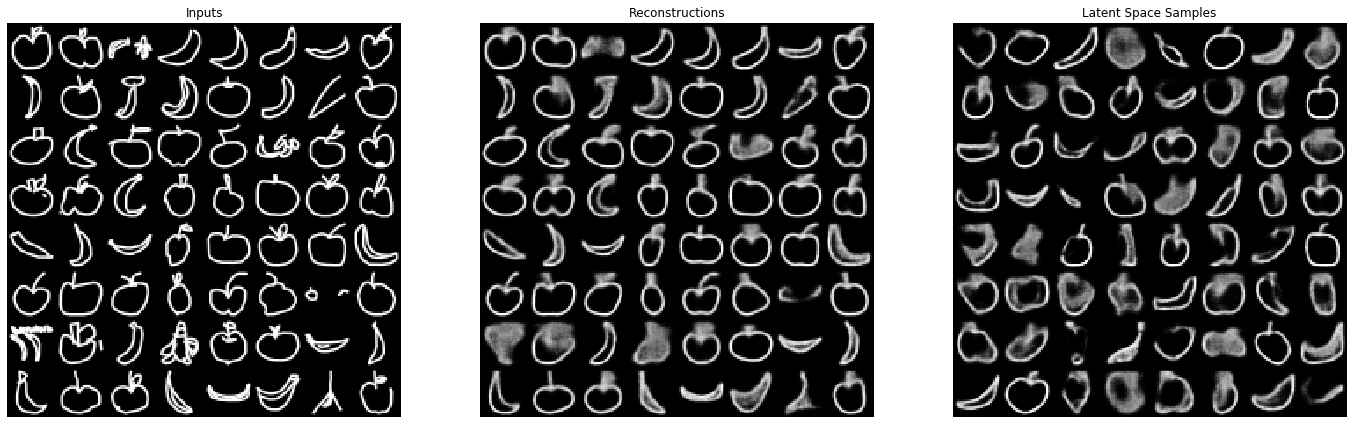

====> Test set loss: 152.0749


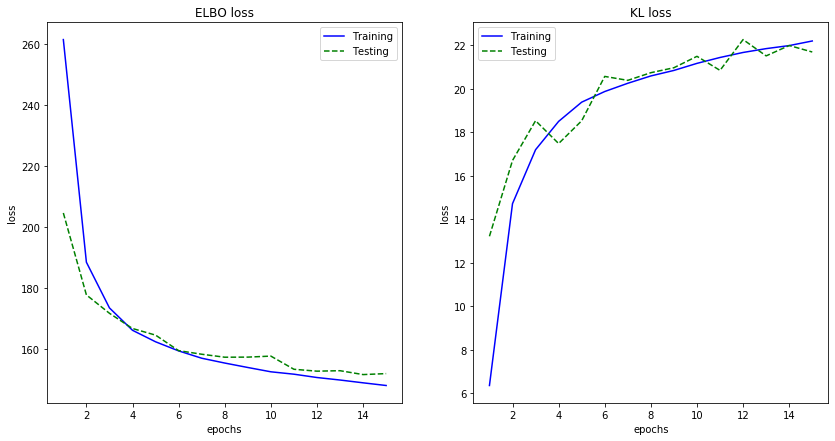

################################################################
Train Epoch: 16 [0/16000 (0%)]	Loss: 146.263016
Train Epoch: 16 [1024/16000 (6%)]	Loss: 145.681366
Train Epoch: 16 [2048/16000 (13%)]	Loss: 150.804367
Train Epoch: 16 [3072/16000 (19%)]	Loss: 148.259308
Train Epoch: 16 [4096/16000 (26%)]	Loss: 155.173370
Train Epoch: 16 [5120/16000 (32%)]	Loss: 146.085510
Train Epoch: 16 [6144/16000 (38%)]	Loss: 139.546051
Train Epoch: 16 [7168/16000 (45%)]	Loss: 146.499710
Train Epoch: 16 [8192/16000 (51%)]	Loss: 149.823730
Train Epoch: 16 [9216/16000 (58%)]	Loss: 149.846634
Train Epoch: 16 [10240/16000 (64%)]	Loss: 145.405060
Train Epoch: 16 [11264/16000 (70%)]	Loss: 147.537872
Train Epoch: 16 [12288/16000 (77%)]	Loss: 148.377640
Train Epoch: 16 [13312/16000 (83%)]	Loss: 149.423340
Train Epoch: 16 [14336/16000 (90%)]	Loss: 148.438492
Train Epoch: 16 [15360/16000 (96%)]	Loss: 146.086472
====> Epoch: 16 Average loss: 148.0959


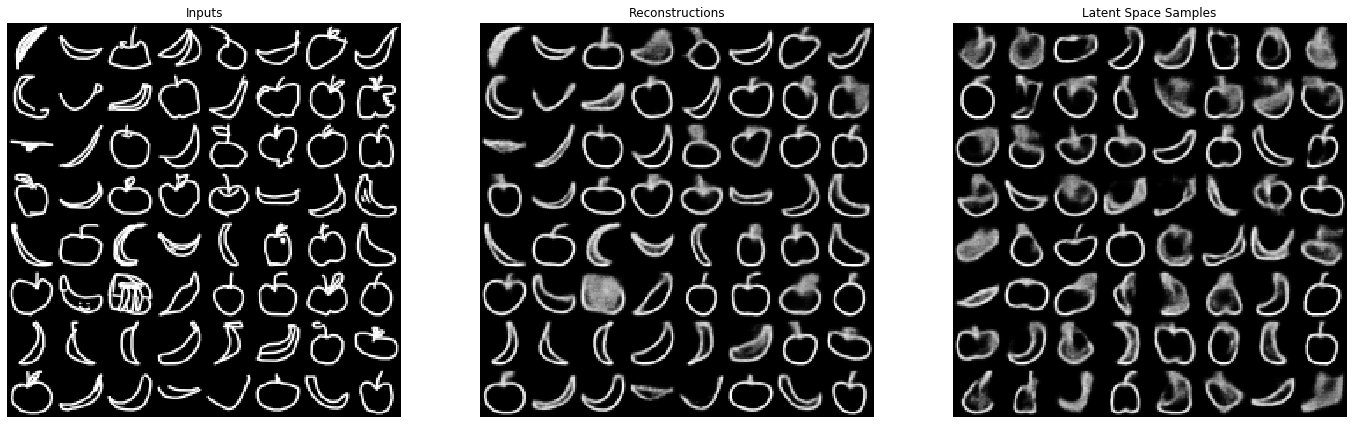

====> Test set loss: 150.9607


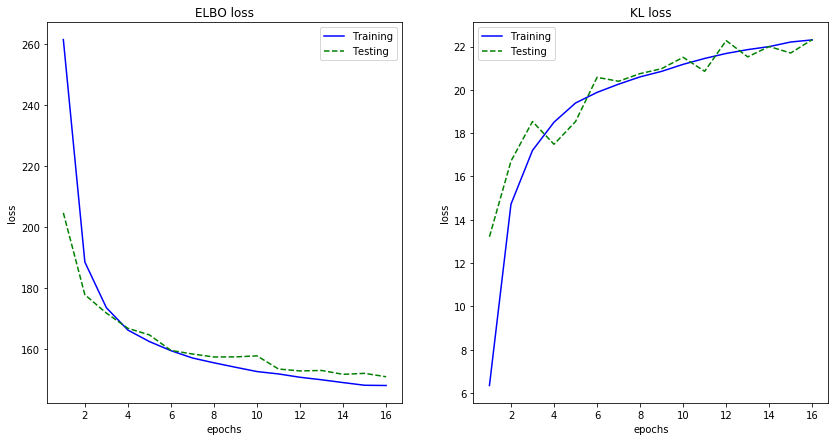

################################################################
Train Epoch: 17 [0/16000 (0%)]	Loss: 150.307327
Train Epoch: 17 [1024/16000 (6%)]	Loss: 148.948685
Train Epoch: 17 [2048/16000 (13%)]	Loss: 149.231415
Train Epoch: 17 [3072/16000 (19%)]	Loss: 149.167358
Train Epoch: 17 [4096/16000 (26%)]	Loss: 147.884781
Train Epoch: 17 [5120/16000 (32%)]	Loss: 143.267578
Train Epoch: 17 [6144/16000 (38%)]	Loss: 143.709991
Train Epoch: 17 [7168/16000 (45%)]	Loss: 149.582611
Train Epoch: 17 [8192/16000 (51%)]	Loss: 148.018509
Train Epoch: 17 [9216/16000 (58%)]	Loss: 158.144897
Train Epoch: 17 [10240/16000 (64%)]	Loss: 152.859314
Train Epoch: 17 [11264/16000 (70%)]	Loss: 147.625397
Train Epoch: 17 [12288/16000 (77%)]	Loss: 144.350571
Train Epoch: 17 [13312/16000 (83%)]	Loss: 139.550018
Train Epoch: 17 [14336/16000 (90%)]	Loss: 150.267273
Train Epoch: 17 [15360/16000 (96%)]	Loss: 149.053940
====> Epoch: 17 Average loss: 147.2972


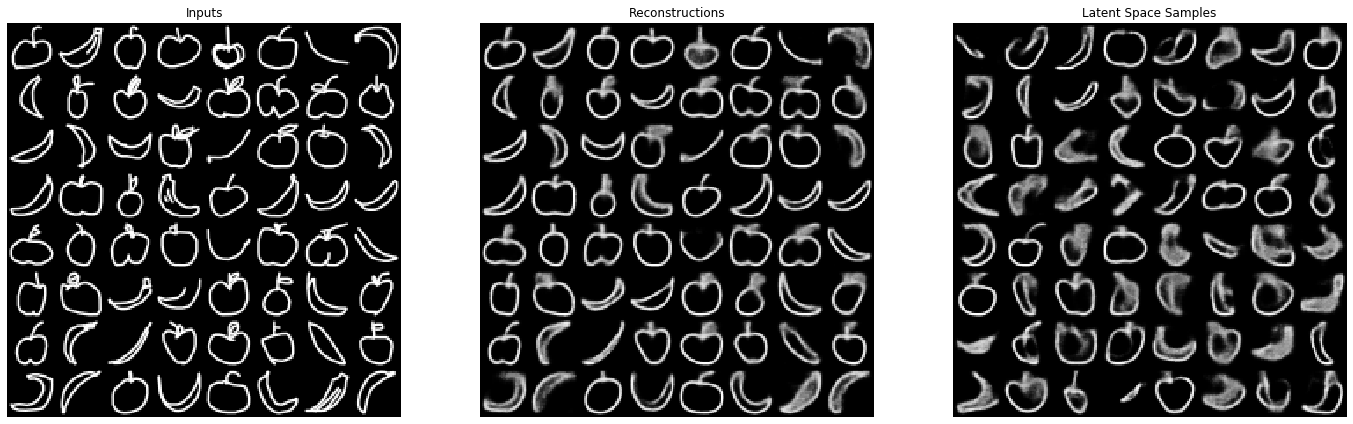

====> Test set loss: 150.1802


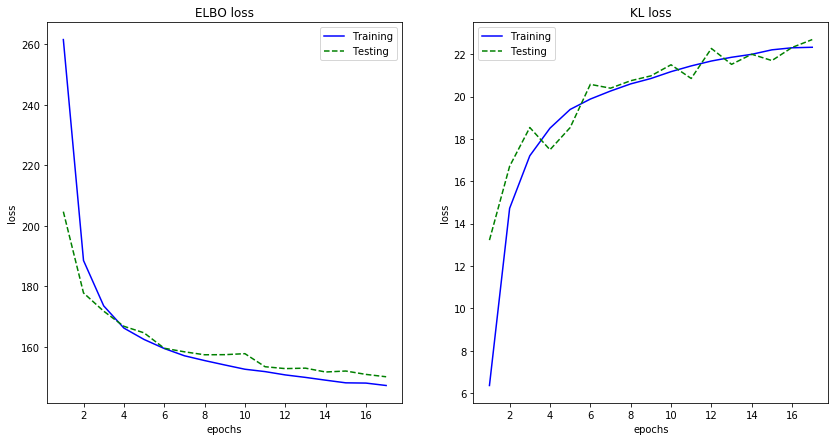

################################################################
Train Epoch: 18 [0/16000 (0%)]	Loss: 145.803146
Train Epoch: 18 [1024/16000 (6%)]	Loss: 142.965744
Train Epoch: 18 [2048/16000 (13%)]	Loss: 141.242172
Train Epoch: 18 [3072/16000 (19%)]	Loss: 143.808411
Train Epoch: 18 [4096/16000 (26%)]	Loss: 138.592712
Train Epoch: 18 [5120/16000 (32%)]	Loss: 147.066711
Train Epoch: 18 [6144/16000 (38%)]	Loss: 151.957062
Train Epoch: 18 [7168/16000 (45%)]	Loss: 141.004608
Train Epoch: 18 [8192/16000 (51%)]	Loss: 140.758057
Train Epoch: 18 [9216/16000 (58%)]	Loss: 143.252136
Train Epoch: 18 [10240/16000 (64%)]	Loss: 146.244568
Train Epoch: 18 [11264/16000 (70%)]	Loss: 151.365005
Train Epoch: 18 [12288/16000 (77%)]	Loss: 153.676804
Train Epoch: 18 [13312/16000 (83%)]	Loss: 144.311066
Train Epoch: 18 [14336/16000 (90%)]	Loss: 141.948349
Train Epoch: 18 [15360/16000 (96%)]	Loss: 149.877396
====> Epoch: 18 Average loss: 146.5236


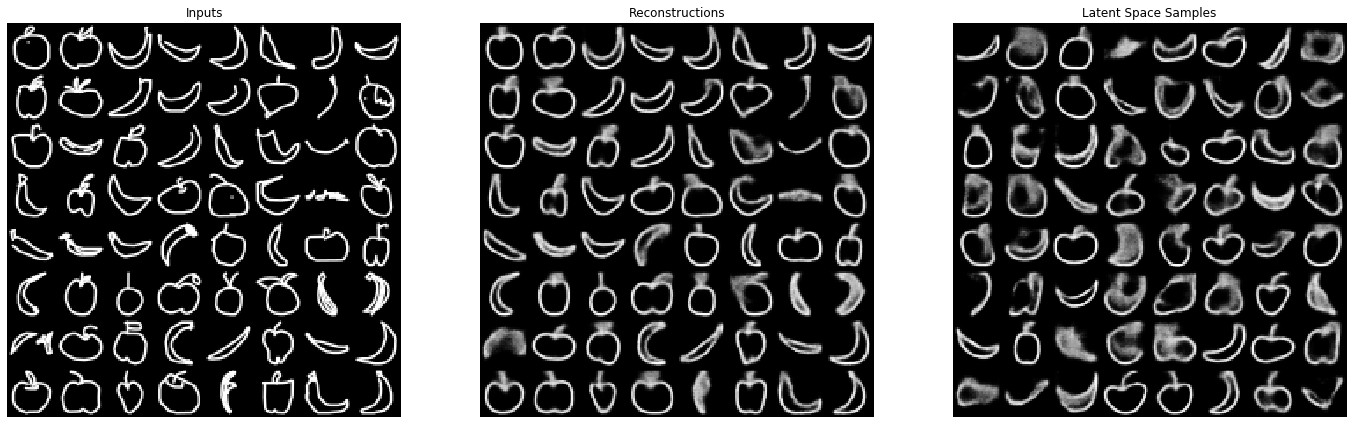

====> Test set loss: 150.4081


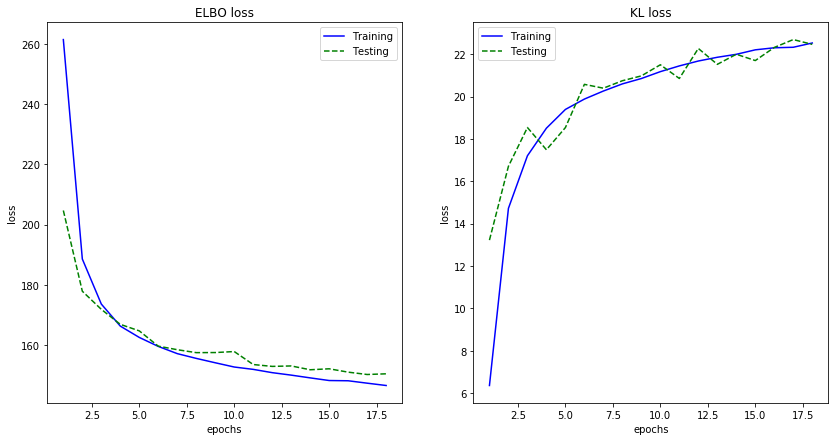

################################################################
Train Epoch: 19 [0/16000 (0%)]	Loss: 144.325302
Train Epoch: 19 [1024/16000 (6%)]	Loss: 146.121185
Train Epoch: 19 [2048/16000 (13%)]	Loss: 143.166107
Train Epoch: 19 [3072/16000 (19%)]	Loss: 143.156906
Train Epoch: 19 [4096/16000 (26%)]	Loss: 159.503983
Train Epoch: 19 [5120/16000 (32%)]	Loss: 144.589050
Train Epoch: 19 [6144/16000 (38%)]	Loss: 139.187622
Train Epoch: 19 [7168/16000 (45%)]	Loss: 156.785828
Train Epoch: 19 [8192/16000 (51%)]	Loss: 166.265396
Train Epoch: 19 [9216/16000 (58%)]	Loss: 143.276367
Train Epoch: 19 [10240/16000 (64%)]	Loss: 138.289703
Train Epoch: 19 [11264/16000 (70%)]	Loss: 145.617264
Train Epoch: 19 [12288/16000 (77%)]	Loss: 143.399170
Train Epoch: 19 [13312/16000 (83%)]	Loss: 153.222916
Train Epoch: 19 [14336/16000 (90%)]	Loss: 151.203506
Train Epoch: 19 [15360/16000 (96%)]	Loss: 149.840912
====> Epoch: 19 Average loss: 146.0971


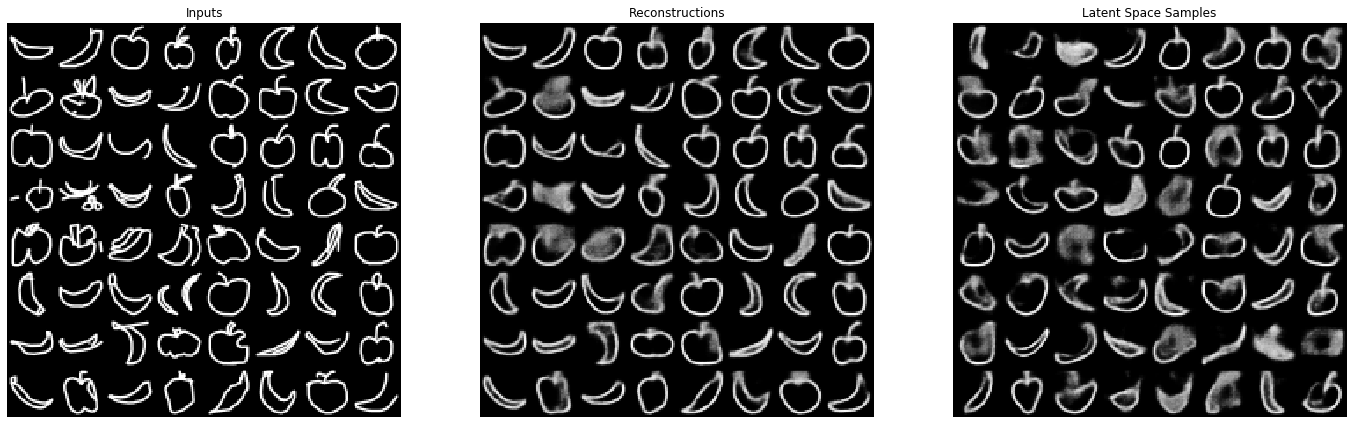

====> Test set loss: 150.3824


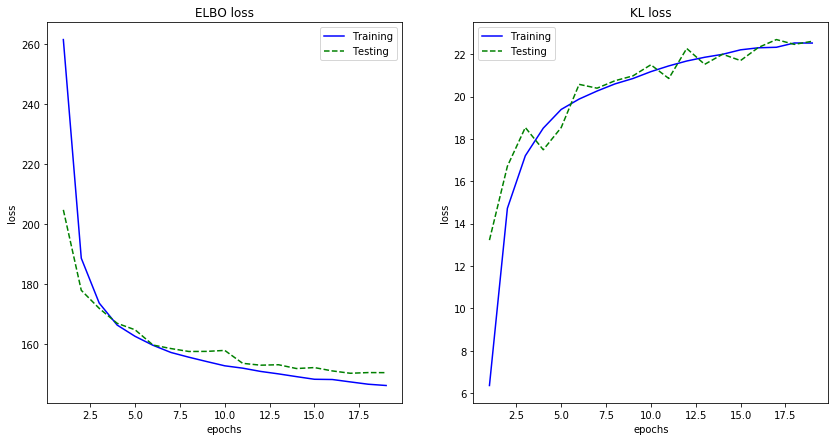

################################################################
Train Epoch: 20 [0/16000 (0%)]	Loss: 146.014084
Train Epoch: 20 [1024/16000 (6%)]	Loss: 143.146851
Train Epoch: 20 [2048/16000 (13%)]	Loss: 140.724792
Train Epoch: 20 [3072/16000 (19%)]	Loss: 154.724503
Train Epoch: 20 [4096/16000 (26%)]	Loss: 151.463257
Train Epoch: 20 [5120/16000 (32%)]	Loss: 144.248276
Train Epoch: 20 [6144/16000 (38%)]	Loss: 150.968201
Train Epoch: 20 [7168/16000 (45%)]	Loss: 143.115143
Train Epoch: 20 [8192/16000 (51%)]	Loss: 143.602539
Train Epoch: 20 [9216/16000 (58%)]	Loss: 149.001053
Train Epoch: 20 [10240/16000 (64%)]	Loss: 148.748169
Train Epoch: 20 [11264/16000 (70%)]	Loss: 143.462616
Train Epoch: 20 [12288/16000 (77%)]	Loss: 148.687012
Train Epoch: 20 [13312/16000 (83%)]	Loss: 145.496140
Train Epoch: 20 [14336/16000 (90%)]	Loss: 155.401443
Train Epoch: 20 [15360/16000 (96%)]	Loss: 141.153290
====> Epoch: 20 Average loss: 145.9306


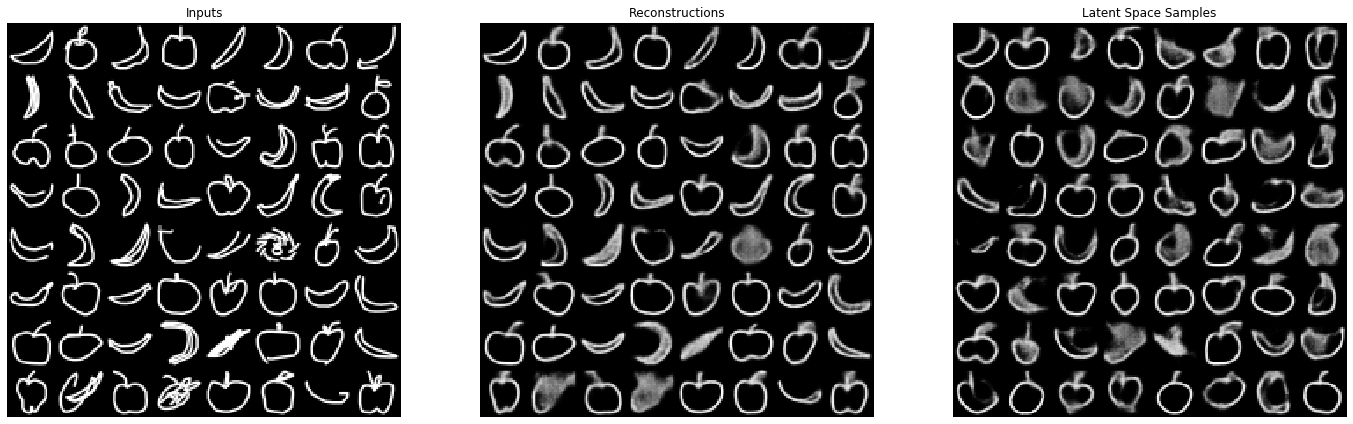

====> Test set loss: 151.4768


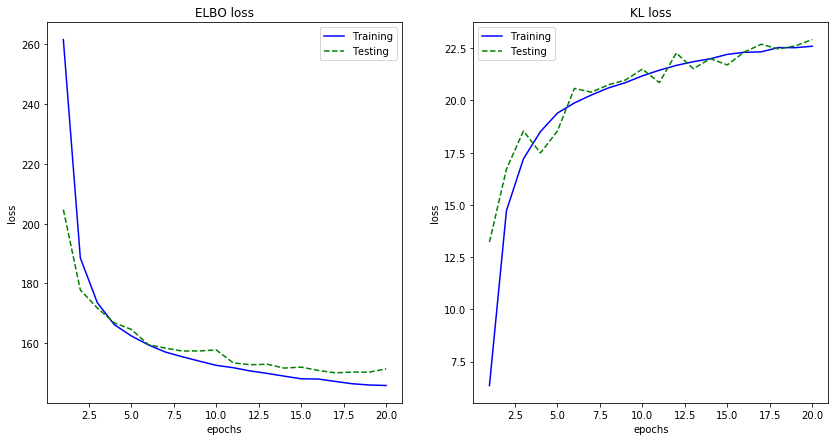

################################################################


In [13]:
model = conv_VAE().to(device) if use_conv else VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

if __name__ == "__main__":

    epoch_list = []
    epoch_loss_train, epoch_kl_train = [], [] # Train losses per epoch (mean of batch losses)
    epoch_loss_test, epoch_kl_test = [], [] # Test losses per epoch (mean of batch losses)
    
    for epoch in range(1, epochs + 1):
        train(epoch)
        test(epoch)
        
        epoch_list.append(epoch)
        if epoch == 1:
            continue

        plot_losses(epoch_list, epoch_loss_train, epoch_loss_test, epoch_kl_train, epoch_kl_test)
        print("################################################################")
            
        # save_image(sample.view(64, 1, 28, 28),
        #            'results/sample_' + str(epoch) + '.png')
        #clear_output(wait=True)


# Interpolation

In [0]:
images, labels = next(iter(train_loader))

In [0]:
def interpolate(images, idx_from, idx_to, steps):

    # get input images
    x_from = images[idx_from].unsqueeze(0)
    x_to = images[idx_to].unsqueeze(0)
    interpolate_images(x_to, x_from, steps)

def interpolate_images(img_from, img_to, steps):

    # get labels
    # lab_to = labels[idx_to]
    # lab_from = labels[idx_from]  

    # get latent space representations of input images
    latent_from = model.reparametrize(*model.encode(img_from.to(device)))
    latent_to = model.reparametrize(*model.encode(img_to.to(device)))

    # actual steps including original images
    n = steps + 1 

    # initialize interpolation vector)
    inter = torch.zeros((n, latent_from.shape[1])).to(device)

    with torch.no_grad():
        alphaValues = np.linspace(0, 1, steps + 1)
        
        for i in range(n):
            alpha = alphaValues[i]
            inter[i] = latent_from * alpha + (1-alpha) * latent_to
        
        output = model.decode(inter).cpu()
        plot_interpolated_images(output)

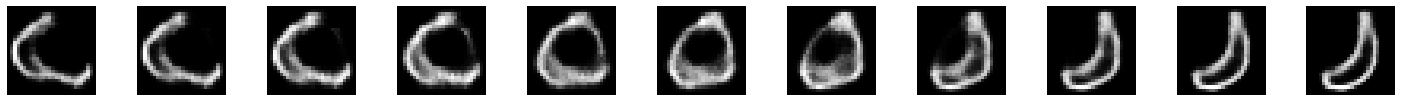

In [0]:
STEPS = 10
INDEX_FROM = 0
INDEX_TO = 4

interpolate(images, INDEX_FROM, INDEX_TO, STEPS)

# Latent space visualization

In [0]:
from sklearn.manifold import TSNE
import seaborn as sns

def encode_all():
    all_latent_vectors, all_labels = [],[]
    tmp_vectors, tmp_labels = [], []

    
    for batch, labels in train_loader:

        for image in batch:
            image.unsqueeze_(0)
            latent_vector = model.reparametrize(*model.encode(image.to(device)))
            
            tmp_vectors.append(latent_vector.unsqueeze(0))

        tmp_labels.append(labels)

    latent_vectors = torch.cat(tmp_vectors)
    all_labels = torch.cat(tmp_labels)
    
    print(latent_vectors.shape)
    print(all_labels.shape)

    return latent_vectors, all_labels

def plot_tsne(data_encoded, labels):
    with torch.no_grad():)
        data_encoded.squeeze_()
        data_embedded = TSNE(n_components=2).fit_transform(data_encoded.cpu())

        palette = sns.color_palette("bright", 2)
        sns.scatterplot(data_embedded[:,0], data_embedded[:,1], hue=labels, legend='full', palette = palette)



In [102]:
data_encoded, labels = encode_all()

torch.Size([16000, 1, 32])
torch.Size([16000])


torch.Size([16000, 1, 32])
torch.Size([16000, 32])


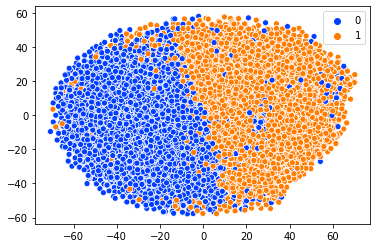

In [103]:
plot_tsne(data_encoded, labels)